# Introduction

"Netflix wants to identify similar movies based on movie characteristics."

The goal of this module is to identify similar movies based on movie characteristics for Netflix. This will be a truly unsupervised learning problem, as there is no target variable. As a result, there is not a known number of clusters ahead of time, so this module will have to explore the appropiate number of clusters.

In [116]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

In [117]:
# data pulled from https://www.kaggle.com/shivamb/netflix-shows
netflix_df = pd.read_csv('netflix_titles.csv', parse_dates=['date_added'])

# Basic EDA

In [118]:
netflix_df.head(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",NaN,2021-09-24,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",The arrival of a charismatic young priest brin...
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,2021-09-24,2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...",2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
8,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,2021-09-24,2021,TV-14,9 Seasons,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,2021-09-24,2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...


Only want to look at movies, so can filter out the TV Shows.

In [119]:
netflix_df = netflix_df[netflix_df['type'] == 'Movie']

In [120]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6131 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       6131 non-null   object        
 1   type          6131 non-null   object        
 2   title         6131 non-null   object        
 3   director      5943 non-null   object        
 4   cast          5656 non-null   object        
 5   country       5691 non-null   object        
 6   date_added    6131 non-null   datetime64[ns]
 7   release_year  6131 non-null   int64         
 8   rating        6129 non-null   object        
 9   duration      6128 non-null   object        
 10  listed_in     6131 non-null   object        
 11  description   6131 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 622.7+ KB


Just about all of the data is non-numerical, so there will be a good amount of one hot encoding to do. There are a few nulls too but these aren't much of a problem. In this case, null values are basically unknown values.

In [121]:
# will just remove things without a length
netflix_df = netflix_df[netflix_df['duration'].notna()]

In [122]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6128 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       6128 non-null   object        
 1   type          6128 non-null   object        
 2   title         6128 non-null   object        
 3   director      5940 non-null   object        
 4   cast          5653 non-null   object        
 5   country       5688 non-null   object        
 6   date_added    6128 non-null   datetime64[ns]
 7   release_year  6128 non-null   int64         
 8   rating        6126 non-null   object        
 9   duration      6128 non-null   object        
 10  listed_in     6128 non-null   object        
 11  description   6128 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 622.4+ KB


In [123]:
netflix_df['director'] = netflix_df['director'].replace(np.nan, 'Unknown')
netflix_df['cast'] = netflix_df['cast'].replace(np.nan, 'Unknown')
netflix_df['country'] = netflix_df['country'].replace(np.nan, 'Unknown')
netflix_df['rating'] = netflix_df['rating'].replace(np.nan, 'Not Rated')

In [124]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6128 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       6128 non-null   object        
 1   type          6128 non-null   object        
 2   title         6128 non-null   object        
 3   director      6128 non-null   object        
 4   cast          6128 non-null   object        
 5   country       6128 non-null   object        
 6   date_added    6128 non-null   datetime64[ns]
 7   release_year  6128 non-null   int64         
 8   rating        6128 non-null   object        
 9   duration      6128 non-null   object        
 10  listed_in     6128 non-null   object        
 11  description   6128 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 622.4+ KB


In [125]:
netflix_df.nunique()

show_id         6128
type               1
title           6128
director        4354
cast            5445
country          652
date_added      1532
release_year      73
rating            15
duration         205
listed_in        278
description     6102
dtype: int64

In [126]:
netflix_df['rating'].value_counts()

TV-MA        2062
TV-14        1427
R             797
TV-PG         540
PG-13         490
PG            287
TV-Y7         139
TV-Y          131
TV-G          126
NR             75
G              41
TV-Y7-FV        5
UR              3
NC-17           3
Not Rated       2
Name: rating, dtype: int64

In [127]:
netflix_df['rating'] = netflix_df['rating'].replace('Not Rated', 'NR')

In [128]:
netflix_df['rating'].value_counts()

TV-MA       2062
TV-14       1427
R            797
TV-PG        540
PG-13        490
PG           287
TV-Y7        139
TV-Y         131
TV-G         126
NR            77
G             41
TV-Y7-FV       5
UR             3
NC-17          3
Name: rating, dtype: int64

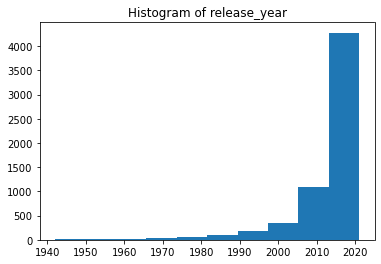

In [129]:
plt.hist(netflix_df["release_year"])
plt.title("Histogram of release_year")
plt.show()

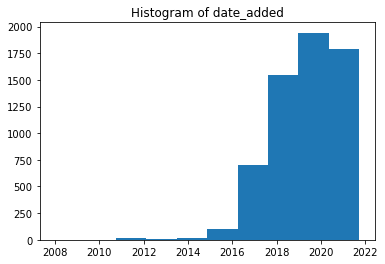

In [130]:
plt.hist(netflix_df["date_added"])
plt.title("Histogram of date_added")
plt.show()

In [131]:
netflix_df['director'].value_counts()

Unknown                   188
Rajiv Chilaka              19
Raúl Campos, Jan Suter     18
Suhas Kadav                16
Marcus Raboy               15
                         ... 
Kathryn Bigelow             1
Adam Deyoe                  1
Avgousta Zourelidi          1
Adam Dubin                  1
Shammi Kapoor               1
Name: director, Length: 4354, dtype: int64

In [132]:
# can drop columns that will not be used in unsupervised learning.
titles_df = netflix_df['title']
netflix_df = netflix_df.drop(['show_id', 'title', 'description'], axis=1)

In [133]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6128 entries, 0 to 8806
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   type          6128 non-null   object        
 1   director      6128 non-null   object        
 2   cast          6128 non-null   object        
 3   country       6128 non-null   object        
 4   date_added    6128 non-null   datetime64[ns]
 5   release_year  6128 non-null   int64         
 6   rating        6128 non-null   object        
 7   duration      6128 non-null   object        
 8   listed_in     6128 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 478.8+ KB


In [134]:
for col in netflix_df.select_dtypes([object]).columns:
    print(f"Column {col} has {len(netflix_df[netflix_df[col].str.contains(',')])} values containing commas.")

Column type has 0 values containing commas.
Column director has 572 values containing commas.
Column cast has 5014 values containing commas.
Column country has 1075 values containing commas.
Column rating has 0 values containing commas.
Column duration has 0 values containing commas.
Column listed_in has 4650 values containing commas.


In [135]:
netflix_df['duration_minutes'] = netflix_df['duration'].str.replace(' min', '').astype(int)
netflix_df = netflix_df.drop(['duration'], axis=1)

In [136]:
netflix_df.head()

,type,director,cast,country,date_added,release_year,rating,listed_in,duration_minutes
0,Movie,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,Documentaries,90
6,Movie,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",Unknown,2021-09-24,2021,PG,Children & Family Movies,91
7,Movie,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...",2021-09-24,1993,TV-MA,"Dramas, Independent Movies, International Movies",125
9,Movie,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,2021-09-24,2021,PG-13,"Comedies, Dramas",104
12,Movie,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic",2021-09-23,2021,TV-MA,"Dramas, International Movies",127


In [137]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6128 entries, 0 to 8806
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   type              6128 non-null   object        
 1   director          6128 non-null   object        
 2   cast              6128 non-null   object        
 3   country           6128 non-null   object        
 4   date_added        6128 non-null   datetime64[ns]
 5   release_year      6128 non-null   int64         
 6   rating            6128 non-null   object        
 7   listed_in         6128 non-null   object        
 8   duration_minutes  6128 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(6)
memory usage: 454.8+ KB


In [138]:
# date_added does nothing for similar characteristics. including the full cast is complete overkill
# also only have ~6000 rows of data. need to keep the feature list smaller
# netflix_df = netflix_df.drop(['type', 'cast', 'date_added', 'director', 'country'], axis=1)
netflix_df = netflix_df.drop(['type', 'cast', 'date_added', 'director', 'country', 'rating', 'release_year', 'duration_minutes'], axis=1)

# Converting variables to features

In [139]:
# netflix_df = pd.concat([netflix_df.drop('director', 1), netflix_df['director'].str.get_dummies(sep=",")], 1)
# netflix_df = pd.concat([netflix_df.drop('country', 1), netflix_df['country'].str.get_dummies(sep=",")], 1)
netflix_df = pd.concat([netflix_df.drop('listed_in', 1), netflix_df['listed_in'].str.get_dummies(sep=",")], 1)

In [140]:
# netflix_df = pd.concat([netflix_df, pd.get_dummies(netflix_df['rating'])], axis=1)
# netflix_df = netflix_df.drop(['rating'], axis=1)

In [141]:
netflix_df.shape

(6128, 37)

In [142]:
netflix_df.head()

,Anime Features,Children & Family Movies,Classic Movies,Comedies,Cult Movies,Documentaries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,...,Independent Movies,International Movies,LGBTQ Movies,Movies,Music & Musicals,Romantic Movies,Sci-Fi & Fantasy,Sports Movies,Stand-Up Comedy,Thrillers
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Decided to remove release_year and duration as well, as they don't describe how similar one movie is with another.

In [143]:
netflix_genres_and_ratings = netflix_df.iloc[:,2:]

In [144]:
scaler = StandardScaler()
netflix_std = scaler.fit_transform(netflix_genres_and_ratings)

# Dimensionality Reduction

**PCA**

Want to visualize data in 2D, so only need two components for PCA.

In [145]:
pca = PCA(n_components=2)

pca_components = pca.fit_transform(netflix_std)

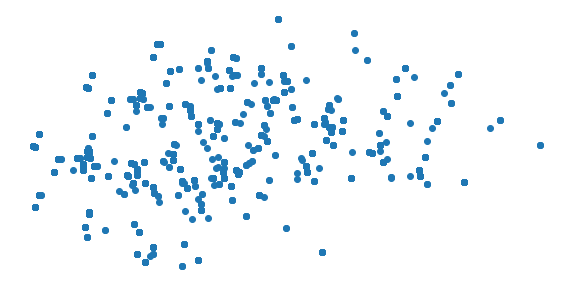

In [146]:
plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

**t-SNE**

In [147]:
from sklearn.manifold import TSNE
import time

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 6128 samples in 0.001s...
[t-SNE] Computed neighbors for 6128 samples in 1.725s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6128
[t-SNE] Computed conditional probabilities for sample 2000 / 6128
[t-SNE] Computed conditional probabilities for sample 3000 / 6128
[t-SNE] Computed conditional probabilities for sample 4000 / 6128
[t-SNE] Computed conditional probabilities for sample 5000 / 6128
[t-SNE] Computed conditional probabilities for sample 6000 / 6128
[t-SNE] Computed conditional probabilities for sample 6128 / 6128
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.322010
[t-SNE] KL divergence after 300 iterations: 1.429403
t-SNE done! Time elapsed: 13.311461687088013 seconds
Perplexity: 5


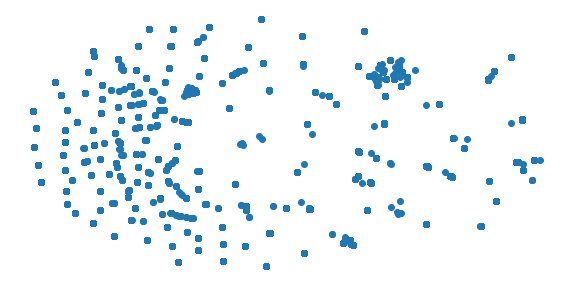

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 6128 samples in 0.002s...
[t-SNE] Computed neighbors for 6128 samples in 1.697s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6128
[t-SNE] Computed conditional probabilities for sample 2000 / 6128
[t-SNE] Computed conditional probabilities for sample 3000 / 6128
[t-SNE] Computed conditional probabilities for sample 4000 / 6128
[t-SNE] Computed conditional probabilities for sample 5000 / 6128
[t-SNE] Computed conditional probabilities for sample 6000 / 6128
[t-SNE] Computed conditional probabilities for sample 6128 / 6128
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.865112
[t-SNE] KL divergence after 300 iterations: 1.152432
t-SNE done! Time elapsed: 13.23058295249939 seconds
Perplexity: 10


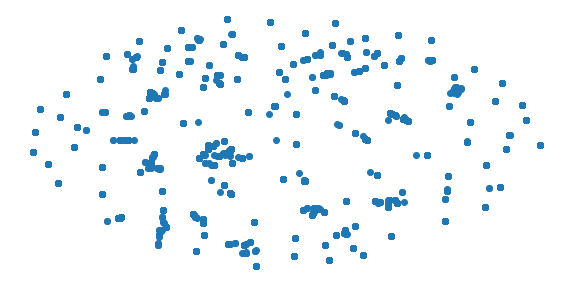

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 6128 samples in 0.000s...
[t-SNE] Computed neighbors for 6128 samples in 1.330s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6128
[t-SNE] Computed conditional probabilities for sample 2000 / 6128
[t-SNE] Computed conditional probabilities for sample 3000 / 6128
[t-SNE] Computed conditional probabilities for sample 4000 / 6128
[t-SNE] Computed conditional probabilities for sample 5000 / 6128
[t-SNE] Computed conditional probabilities for sample 6000 / 6128
[t-SNE] Computed conditional probabilities for sample 6128 / 6128
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.493103
[t-SNE] KL divergence after 300 iterations: 0.962814
t-SNE done! Time elapsed: 12.134307146072388 seconds
Perplexity: 20


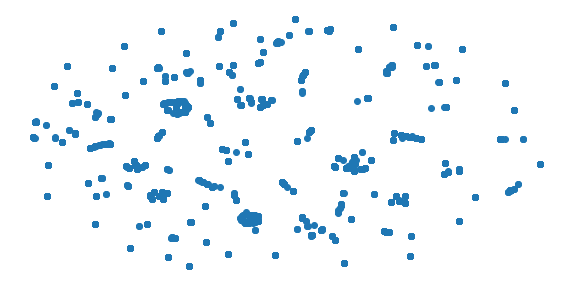

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6128 samples in 0.000s...
[t-SNE] Computed neighbors for 6128 samples in 1.362s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6128
[t-SNE] Computed conditional probabilities for sample 2000 / 6128
[t-SNE] Computed conditional probabilities for sample 3000 / 6128
[t-SNE] Computed conditional probabilities for sample 4000 / 6128
[t-SNE] Computed conditional probabilities for sample 5000 / 6128
[t-SNE] Computed conditional probabilities for sample 6000 / 6128
[t-SNE] Computed conditional probabilities for sample 6128 / 6128
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.571510
[t-SNE] KL divergence after 300 iterations: 0.865213
t-SNE done! Time elapsed: 15.04858136177063 seconds
Perplexity: 30


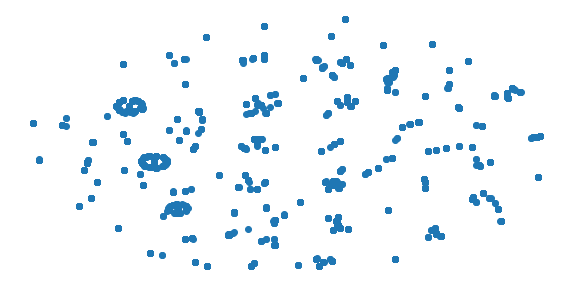

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6128 samples in 0.001s...
[t-SNE] Computed neighbors for 6128 samples in 1.708s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6128
[t-SNE] Computed conditional probabilities for sample 2000 / 6128
[t-SNE] Computed conditional probabilities for sample 3000 / 6128
[t-SNE] Computed conditional probabilities for sample 4000 / 6128
[t-SNE] Computed conditional probabilities for sample 5000 / 6128
[t-SNE] Computed conditional probabilities for sample 6000 / 6128
[t-SNE] Computed conditional probabilities for sample 6128 / 6128
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.719685
[t-SNE] KL divergence after 300 iterations: 0.772107
t-SNE done! Time elapsed: 19.22133493423462 seconds
Perplexity: 40


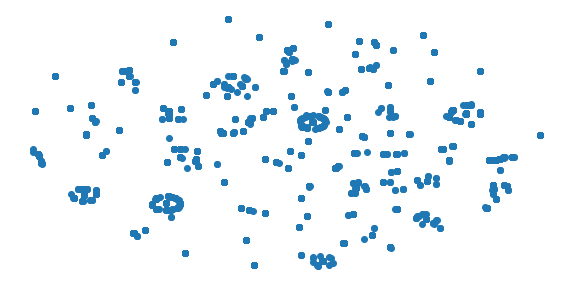

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6128 samples in 0.000s...
[t-SNE] Computed neighbors for 6128 samples in 2.167s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6128
[t-SNE] Computed conditional probabilities for sample 2000 / 6128
[t-SNE] Computed conditional probabilities for sample 3000 / 6128
[t-SNE] Computed conditional probabilities for sample 4000 / 6128
[t-SNE] Computed conditional probabilities for sample 5000 / 6128
[t-SNE] Computed conditional probabilities for sample 6000 / 6128
[t-SNE] Computed conditional probabilities for sample 6128 / 6128
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.026188
[t-SNE] KL divergence after 300 iterations: 0.724606
t-SNE done! Time elapsed: 19.778972148895264 seconds
Perplexity: 50


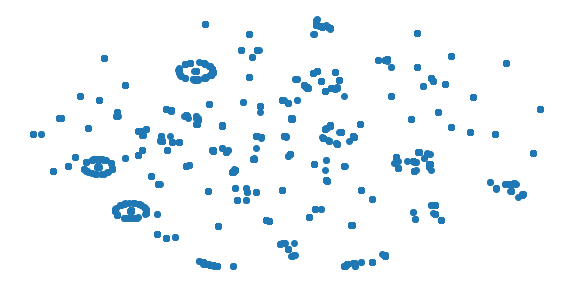

In [148]:
# trying different perplexities:
for n in (5, 10, 20, 30, 40, 50):
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=n, n_iter=300)
    tsne_results = tsne.fit_transform(netflix_std)

    print(f't-SNE done! Time elapsed: {time.time()-time_start} seconds')
    print(f'Perplexity: {n}')

    plt.figure(figsize=(10,5))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

**UMAP**

In [149]:
import umap

UMAP done! Time elapsed: 10.830524682998657 seconds
n_neighbors: 2


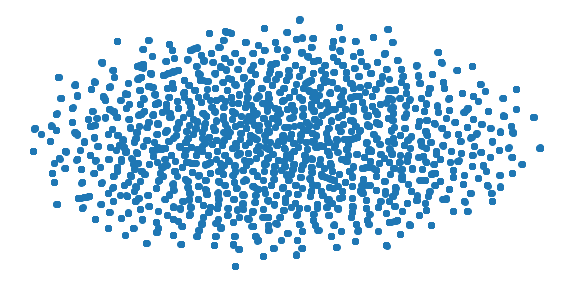

UMAP done! Time elapsed: 10.623998880386353 seconds
n_neighbors: 5


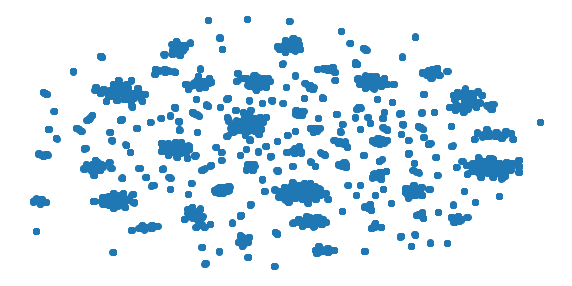

UMAP done! Time elapsed: 14.844510316848755 seconds
n_neighbors: 10


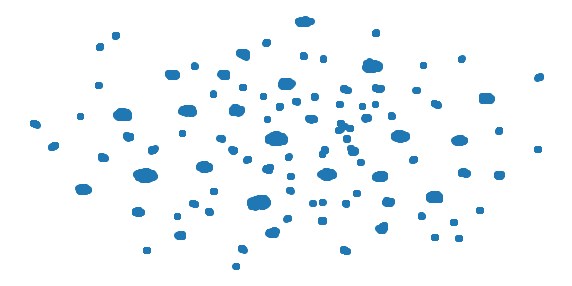

UMAP done! Time elapsed: 29.173866987228394 seconds
n_neighbors: 20


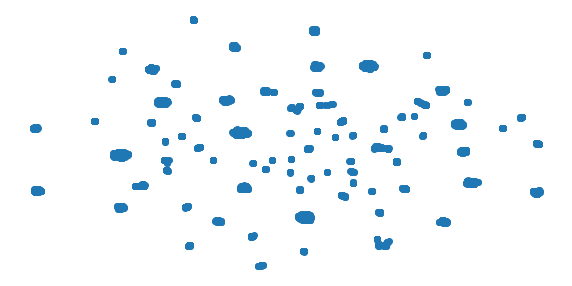

UMAP done! Time elapsed: 46.77544379234314 seconds
n_neighbors: 50


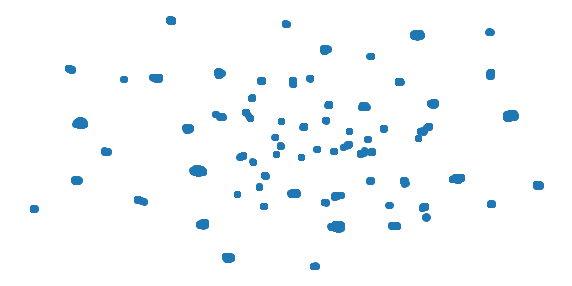

UMAP done! Time elapsed: 95.65814185142517 seconds
n_neighbors: 100


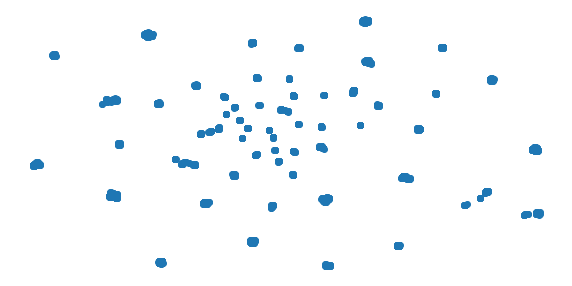

UMAP done! Time elapsed: 224.65321564674377 seconds
n_neighbors: 200


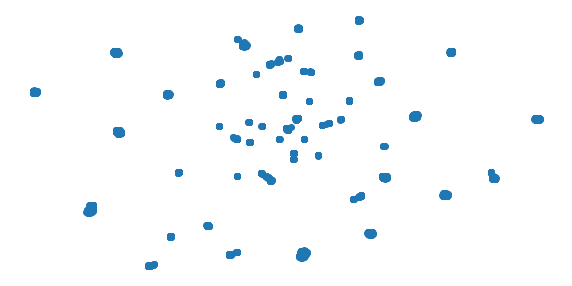

In [150]:
# trying different n_neighbors
for n in (2, 5, 10, 20, 50, 100, 200):
    time_start = time.time()

    umap_results = umap.UMAP(n_neighbors=n,
                          min_dist=0.3,
                          metric='correlation').fit_transform(netflix_std)

    print(f'UMAP done! Time elapsed: {time.time()-time_start} seconds')
    print(f'n_neighbors: {n}')

    plt.figure(figsize=(10,5))
    plt.scatter(umap_results[:, 0], umap_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

UMAP done! Time elapsed: 38.06059908866882 seconds
min_dist: 0.1


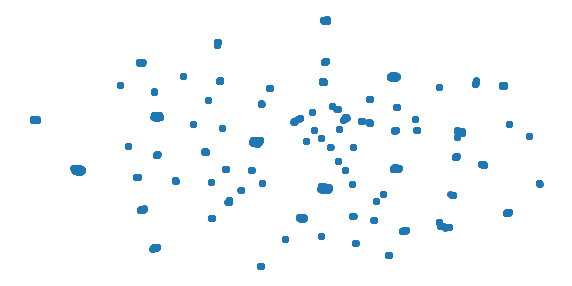

UMAP done! Time elapsed: 35.49212574958801 seconds
min_dist: 0.2


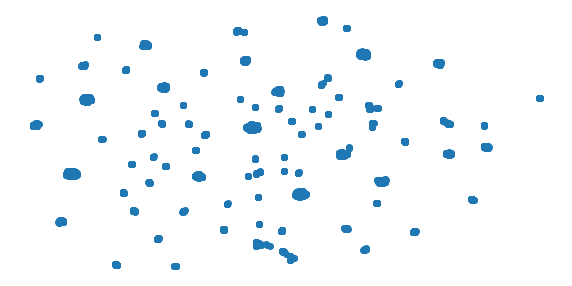

UMAP done! Time elapsed: 35.64739680290222 seconds
min_dist: 0.4


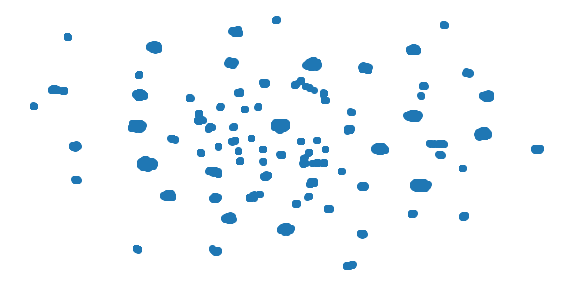

UMAP done! Time elapsed: 36.942617416381836 seconds
min_dist: 0.5


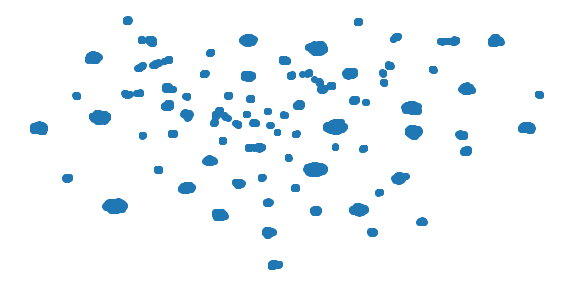

UMAP done! Time elapsed: 42.498326778411865 seconds
min_dist: 0.7


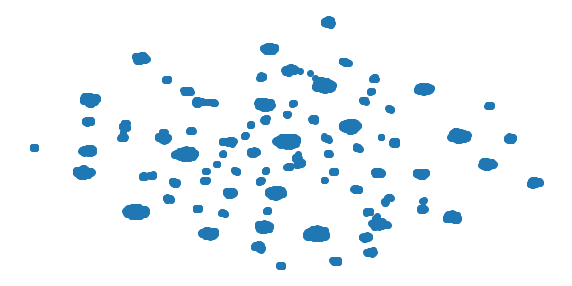

UMAP done! Time elapsed: 40.44350290298462 seconds
min_dist: 1.0


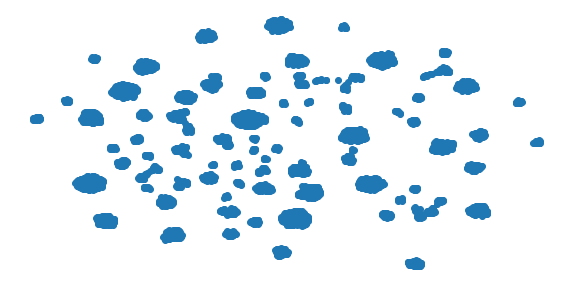

In [151]:
# trying out some min_dist changes now. n_neighbors = 20 looks the best visually

for n in (0.1, 0.2, 0.4, 0.5, 0.7, 1.0):
    time_start = time.time()

    umap_results = umap.UMAP(n_neighbors=20,
                          min_dist=n,
                          metric='correlation').fit_transform(netflix_std)

    print(f'UMAP done! Time elapsed: {time.time()-time_start} seconds')
    print(f'min_dist: {n}')

    plt.figure(figsize=(10,5))
    plt.scatter(umap_results[:, 0], umap_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

UMAP with n_neighbors=20 and min_dist=1.0 visually looks like it clustered everything the best. There are a large number of clusters, but there are a large number of movie genres/groups, so this makes sense.

# Clustering

**K-means**

In [152]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [154]:
for n in (100, 200, 250, 263):
    k_means = KMeans(n_clusters=n, random_state=123)
    %timeit k_means.fit(netflix_std)
    y_pred = k_means.predict(netflix_std)

    print(f'Value of n: {n}')
    print(metrics.silhouette_score(netflix_std, y_pred, metric='euclidean'))

3.01 s ± 735 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Value of n: 100
0.892505756088889
4.98 s ± 1.22 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Value of n: 200
0.9750099592118449
7.94 s ± 403 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Value of n: 250
0.9878324166169496
8.06 s ± 304 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Value of n: 263
0.9895561336859118


The silhouette score ends up converging on the maximum number of distinct clusters, which is 263.

In [155]:
netflix_titles_df = netflix_df.join(titles_df)

In [156]:
reset_index_df = netflix_titles_df.reset_index()

In [157]:
y_pred_df = pd.DataFrame(y_pred, columns=['cluster_prediction'])

In [158]:
cluster_df = reset_index_df.join(y_pred_df)

In [159]:
cluster_df.head()

,index,Anime Features,Children & Family Movies,Classic Movies,Comedies,Cult Movies,Documentaries,Dramas,Faith & Spirituality,Horror Movies,...,LGBTQ Movies,Movies,Music & Musicals,Romantic Movies,Sci-Fi & Fantasy,Sports Movies,Stand-Up Comedy,Thrillers,title,cluster_prediction
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Dick Johnson Is Dead,2
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,My Little Pony: A New Generation,8
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Sankofa,25
3,9,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,The Starling,121
4,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Je Suis Karl,4


Now have 263 clusters of similar groups of movies. We can loop through each cluster and view which movies are considered similar. 

In [195]:
for n in range(263):
    print(f'cluster #{n} movies:')
    print(cluster_df[cluster_df['cluster_prediction'] == n]['title'].head().to_string(index=False))
    print('')

cluster #0 movies:
          The Stronghold
 Shootout at Lokhandwala
How I Became a Superhero
       Jagame Thandhiram
           Silver Skates

cluster #1 movies:
                    Grown Ups
Janoskians: Untold and Untrue
  Welcome Home Roscoe Jenkins
                  Major Payne
                         Poms

cluster #2 movies:
                       Dick Johnson Is Dead
                     My Heroes Were Cowboys
                              Final Account
Bob Ross: Happy Accidents, Betrayal & Greed
        Lady Boss: The Jackie Collins Story

cluster #3 movies:
 Lokillo: Nothing's the Same
The Original Kings of Comedy
                The Stand-Up
Lee Su-geun: The Sense Coach
     Alan Saldaña: Locked Up

cluster #4 movies:
            Je Suis Karl
            King of Boys
              Thimmarusu
Nneka The Pretty Serpent
                 Unroyal

cluster #5 movies:
Paradise Hills
      Level 16
      Prospect
      Selfless
           TAU

cluster #6 movies:
  Intrusion
   Parano

cluster #99 movies:
Rattlesnake
        Cam
    Creep 2
      Creep
 13 Cameras

cluster #100 movies:
Killer Klowns from Outer Space
                  Murder Party
                       Tremors

cluster #101 movies:
Battlefield Earth
          Hellboy
         The Crow

cluster #102 movies:
Mission Istaanbul: Darr Ke Aagey Jeet Hai
              The Knight and the Princess
                                    Don 2
                                     Race
                                   Race 2

cluster #103 movies:
      The Brave
           Darc
         A.X.L.
       Bushwick
Hunter's Prayer

cluster #104 movies:
Rosemary's Baby

cluster #105 movies:
Austin Powers: The Spy Who Shagged Me
                      Vampire Academy
                 Ant-Man and the Wasp
                         Men in Black
                      Men in Black II

cluster #106 movies:
                                     My Girl 2
               Four Sisters Before the Wedding
An American Girl: McKenna Sho

Soul Surfer

cluster #203 movies:
Evan Almighty

cluster #204 movies:
Kitty Love: An Homage to Cats
           My Octopus Teacher
              Untamed Romania
                  Beary Tales
    El Viaje: Márama y Rombai

cluster #205 movies:
Sweeney Todd: The Demon Barber of Fleet Street

cluster #206 movies:
The Lonely Island Presents: The Unauthorized Ba...

cluster #207 movies:
Zoot Suit

cluster #208 movies:
   Action Replayy
     Stunt School
         Misfit 2
Holy Expectations
           Misfit

cluster #209 movies:
A Week Away

cluster #210 movies:
   Eurovision Song Contest: The Story of Fire Saga
Michael Bolton's Big, Sexy Valentine's Day Special

cluster #211 movies:
Krishna Cottage
  Blood Red Sky
      Daemonium
        Rampant
 Train to Busan

cluster #212 movies:
Words Bubble Up Like Soda Pop
          Children of the Sea
               A Whisker Away
               A Silent Voice
  In This Corner of the World

cluster #213 movies:
The Prom

cluster #214 movies:
The Weddi

Scrolling through the clusters, everything seemed to work out nicely! Original movies and their sequels can be seen in many groups of clusters.

**DBSCAN**

Since there is such a large amount of clusters, and that amount is not known, we will be using the DBSCAN approach. The DBSCAN approach does not require you to specify the number of clusters.

In [196]:
from sklearn.cluster import DBSCAN

In [200]:
#trying out different eps
for n in (1, 2, 3, 4, 5):
    dbscan_cluster = DBSCAN(eps=n, min_samples=5)
    dbscan_clusters = dbscan_cluster.fit_predict(netflix_std)

    print(f'Value of eps: {n}')
    print(metrics.silhouette_score(netflix_std, dbscan_clusters, metric='euclidean'))

Value of eps: 1
0.9326836739681906
Value of eps: 2
0.9326836739681906
Value of eps: 3
0.6900758138730336
Value of eps: 4
0.3624113446526009
Value of eps: 5
0.3252146174532277


In [202]:
# will stick with eps=1. now trying different min_samples
for n in (5, 4, 3, 2, 1):
    dbscan_cluster = DBSCAN(eps=1, min_samples=n)
    dbscan_clusters = dbscan_cluster.fit_predict(netflix_std)

    print(f'Value of min_samples: {n}')
    print(metrics.silhouette_score(netflix_std, dbscan_clusters, metric='euclidean'))

Value of min_samples: 5
0.9326836739681906
Value of min_samples: 4
0.9434271335724421
Value of min_samples: 3
0.9613706414432999
Value of min_samples: 2
0.9819179502735705
Value of min_samples: 1
0.9895561336859118


DBSCAN is hard-clustering and min_samples=1. The results here are actually identical to K-means.

**GMM**

In [203]:
from sklearn.mixture import GaussianMixture

In [206]:
#trying out different n_components
for n in (5, 50, 100, 150, 200, 250, 263):
    gmm_cluster = GaussianMixture(n_components=n, random_state=123)
    gmm_clusters = gmm_cluster.fit_predict(netflix_std)

    print(f'Value of n_components: {n}')
    print(metrics.silhouette_score(netflix_std, gmm_clusters, metric='euclidean'))

Value of n_components: 5
0.10803421955106426
Value of n_components: 50
0.7304829236126184
Value of n_components: 100
0.8909977850983392
Value of n_components: 150
0.9402439434537632
Value of n_components: 200
0.9749626241329828
Value of n_components: 250
0.987820775152635
Value of n_components: 263
0.9895561336859118


GMM is producing identical results as well. The movies are being clustered by genres. Since there are so many movies with identical genres, those movies are clustering perfectly. Adding in a continuous feature in the dataset would change this, but there is no need.

# Conclusion

The movies ended up being clustered where all their genres and subgenres were identical. This actually worked out quite well. At one point in this module, it was attempted to include more features in the modeling dataset, such as including the director or the cast. This ended up creating more features than actual movies, which would have made clustering ineffective. That idea was then scrapped and it was decided to only keep genres. If a substantial amount of movies are added to Netflix, then using more features may be feasible. For the number of current movies listed, using only genres works fine. The clusters of movie recommendations are listed again below for reference.

In [207]:
for n in range(263):
    print(f'cluster #{n} movies:')
    print(cluster_df[cluster_df['cluster_prediction'] == n]['title'].head().to_string(index=False))
    print('')

cluster #0 movies:
          The Stronghold
 Shootout at Lokhandwala
How I Became a Superhero
       Jagame Thandhiram
           Silver Skates

cluster #1 movies:
                    Grown Ups
Janoskians: Untold and Untrue
  Welcome Home Roscoe Jenkins
                  Major Payne
                         Poms

cluster #2 movies:
                       Dick Johnson Is Dead
                     My Heroes Were Cowboys
                              Final Account
Bob Ross: Happy Accidents, Betrayal & Greed
        Lady Boss: The Jackie Collins Story

cluster #3 movies:
 Lokillo: Nothing's the Same
The Original Kings of Comedy
                The Stand-Up
Lee Su-geun: The Sense Coach
     Alan Saldaña: Locked Up

cluster #4 movies:
            Je Suis Karl
            King of Boys
              Thimmarusu
Nneka The Pretty Serpent
                 Unroyal

cluster #5 movies:
Paradise Hills
      Level 16
      Prospect
      Selfless
           TAU

cluster #6 movies:
  Intrusion
   Parano

                  The Princess Switch

cluster #94 movies:
     Birth of the Dragon
Clear and Present Danger
                Poseidon
        Tears of the Sun
              Sweet Girl

cluster #95 movies:
              Takizawa Kabuki ZERO 2020 The Movie
Sam Smith: Love Goes - Live at Abbey Road Studios
             Perfume Imaginary Museum “Time Warp”
              Reframe THEATER EXPERIENCE with you
                       PNL - Dans la légende tour

cluster #96 movies:
       Letters to Juliet
              Home Again
      Life as We Know It
                 Flipped
The Mirror Has Two Faces

cluster #97 movies:
               Snowpiercer
         The Beast Stalker
                     Elaan
Legendary Weapons of China
           The Five Venoms

cluster #98 movies:
 In Paradox
 MindGamers
I Am Mother
 The Worthy
Lucid Dream

cluster #99 movies:
Rattlesnake
        Cam
    Creep 2
      Creep
 13 Cameras

cluster #100 movies:
Killer Klowns from Outer Space
                  Murder Par

The Lonely Island Presents: The Unauthorized Ba...

cluster #207 movies:
Zoot Suit

cluster #208 movies:
   Action Replayy
     Stunt School
         Misfit 2
Holy Expectations
           Misfit

cluster #209 movies:
A Week Away

cluster #210 movies:
   Eurovision Song Contest: The Story of Fire Saga
Michael Bolton's Big, Sexy Valentine's Day Special

cluster #211 movies:
Krishna Cottage
  Blood Red Sky
      Daemonium
        Rampant
 Train to Busan

cluster #212 movies:
Words Bubble Up Like Soda Pop
          Children of the Sea
               A Whisker Away
               A Silent Voice
  In This Corner of the World

cluster #213 movies:
The Prom

cluster #214 movies:
The Wedding Guest
          Rebecca

cluster #215 movies:
              Layer Cake
            The Occupant
             In Darkness
     Bad Day for the Cut
Deadline: Sirf 24 Ghante

cluster #216 movies:
Zodiac

cluster #217 movies:
Jem and the Holograms
     The Wishing Tree

cluster #218 movies:
Under an Arctic Sky
